In [1]:
from scipy.optimize import least_squares, minimize, LinearConstraint, NonlinearConstraint, BFGS, SR1
import scipy.optimize as scopt
import numpy as np
import matplotlib.pyplot as plt
from toy_datasets import ToyDatasets
from scipy.stats import norm
import jax.numpy as jnp
import jax.random as jrd
from jax import jit, value_and_grad, jacrev
import jax
from functools import partial
import pandas as pd
import yfinance as yf

In [2]:
class Stage6Algorithm():
  def __init__(self, num_features, ar_order):
    self.num_features, self.ar_order = num_features, ar_order
    self.X, self.G, self.S, self.K = None, None, None, None
    self.dims = None

  def objective(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S = params[:X_len], params[X_len:X_len+G_len], params[X_len+G_len:X_len+G_len+S_len]
    X, G, S = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape)

    objective_value = np.linalg.norm(G) ** 2 + np.linalg.norm(S, 1)

    return objective_value

  def hankel_constraint(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, K_t = params[:X_len], params[X_len+G_len+S_len:]
    X, K_t = X.reshape(X_shape), K_t.reshape(K_shape)
    K = self.K
    K[-self.num_features:] = K_t

    X1, X2 = X[:, :-1], X[:, 1:]
    X1, X2 = X1[:, self.idx_ravel].reshape(self.num_features * self.ar_order, -1), X2[:, self.idx_ravel].reshape(self.num_features * self.ar_order, -1)
    return (X2 - K @ X1).flatten()

  def D_constraint(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S = params[:X_len], params[X_len:X_len+G_len], params[X_len+G_len:X_len+G_len+S_len]
    X, G, S = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape)
    return (self.D - X - G - S).flatten()
    
  def fit(self, D, bounds=None, retrain=False):
    if retrain:
      print("Using learned parameters")
      len_diff = D.shape[1] - self.X.shape[1]
      if len_diff == 0:
        X_initial_guess = self.X
      else:
        X_initial_guess = np.hstack((self.X, self.forecast(self.X, len_diff)))
      G_initial_guess, S_initial_guess, K_initial_guess = \
        np.hstack((self.G, np.zeros((D.shape[0], len_diff)))), np.hstack((self.S, np.zeros((D.shape[0], len_diff)))), self.K
    else:
      print("Learning from scratch")
      X_initial_guess, G_initial_guess, S_initial_guess, K_initial_guess = \
        D, np.random.normal(0, 0.01, D.shape), np.random.standard_t(3, D.shape) / 100, np.zeros((self.num_features, self.num_features*self.ar_order))

    min_val, max_val = D.min(axis=1).reshape(-1, 1), D.max(axis=1).reshape(-1, 1)
    self.min_val, self.max_val = min_val, max_val

    D = (D - min_val) / (max_val - min_val)
    X_initial_guess = (X_initial_guess - min_val) / (max_val - min_val)
    G_initial_guess = G_initial_guess / (max_val - min_val)
    S_initial_guess = S_initial_guess / (max_val - min_val)

    params = np.concatenate([X_initial_guess.flatten(), G_initial_guess.flatten(), S_initial_guess.flatten(), K_initial_guess.flatten()])
    dims = (
      (X_initial_guess.shape, len(X_initial_guess.flatten())),
      (G_initial_guess.shape, len(G_initial_guess.flatten())),
      (S_initial_guess.shape, len(S_initial_guess.flatten())),
      (K_initial_guess.shape, len(K_initial_guess.flatten()))
    )
    self.dims = dims

    self.D = D
    self.idx_ravel = (np.arange(self.ar_order)[:, None] + np.arange(D.shape[1] - self.ar_order)).ravel()

    K = np.zeros((self.num_features * self.ar_order, self.num_features * self.ar_order))
    rows, cols = np.diag_indices(self.num_features * self.ar_order - self.num_features)
    K[rows, cols + self.num_features] = 1
    self.K = K

    hankel_constraint = NonlinearConstraint(self.hankel_constraint, 0, 0)
    D_constraint = NonlinearConstraint(self.D_constraint, 0, 0)

    # constraints = (
    #   {'type': 'eq', 'fun': self.hankel_constraint, 'args': (K, dims[0][0], dims[0][1], dims[1][1], dims[2][1], dims[3][0], idx_ravel)},
    #   {'type': 'eq', 'fun': self.D_constraint, 'args': (D, dims[0][0], dims[0][1], dims[1][0], dims[1][1], dims[2][0], dims[2][1])},
    # )
    constraints = [hankel_constraint, D_constraint]

    options = {
      'disp': True,
      'maxiter': 1000,
      'gtol': 1e-6,
      'xtol': 1e-6
    }

    # obj_and_grad = jit(value_and_grad(self.objective))
    result = minimize(self.objective, params, method='trust-constr', constraints=constraints, options=options, jac='2-point', hess=BFGS())

    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S, K = result.x[:X_len], result.x[X_len:X_len+G_len], result.x[X_len+G_len:X_len+G_len+S_len], result.x[X_len+G_len+S_len:]
    X, G, S, K = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape), K.reshape(K_shape)

    X, G, S = X * (max_val - min_val) + min_val, G * (max_val - min_val), S * (max_val - min_val)
    self.X, self.G, self.S, self.K = X, G, S, K

  def forecast(self, x, timesteps):
    x = (x - self.min_val) / (self.max_val - self.min_val)
    current_window = x[:, -(self.ar_order+self.num_features)+1:]
    forecasted = np.zeros((self.num_features, timesteps))
    idx_ravel = (np.arange(self.ar_order)[:, None] + np.arange(current_window.shape[1] - self.ar_order + 1)).ravel()
    for i in range(timesteps):
      hankel_window = current_window[:, idx_ravel].reshape(self.num_features * self.ar_order, -1)
      next_el = (self.K @ hankel_window)[:, -1]
      forecasted[:, i] = next_el
      current_window = np.hstack((current_window, next_el.reshape(-1, 1)))[:, 1:]
    forecasted = forecasted * (self.max_val - self.min_val) + self.min_val
    return forecasted
  
  def evaluate(self, y, y_predicted):
    return np.sqrt(1/len(y) * np.sum(np.square(y - y_predicted)))

In [ ]:
# 1m26s, 192it - BFGS
# 2m2s, 226it - SR1
np.random.seed(0)
num_elements, num_features, order, test_len = 100, 3, 1, 10
toy_datasets = ToyDatasets(num_elements=num_elements)
toy_data_full = toy_datasets.financial(num_features=num_features).T

# get first n elements
n=80
toy_data = toy_data_full[:, :n]

# run model on these 80 values
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage6Algorithm(num_features=num_features, ar_order=order)

alg.fit(train_data, retrain=False)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [ ]:
# increase dataset to 90 elements
n=85
toy_data = toy_data_full[:, :n]

# run model on these 90 values with retrain set to true
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]

alg.fit(train_data, retrain=True)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [ ]:
np.random.seed(0)
num_elements, num_features, order, test_len = 220, 3, 1, 10
toy_datasets = ToyDatasets(num_elements=num_elements)
toy_data_full = toy_datasets.financial(num_features=num_features).T

# get first n elements
n=200
toy_data = toy_data_full[:, :n]

# run model on these 80 values
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage6Algorithm(num_features=num_features, ar_order=order)

alg.fit(train_data, retrain=False)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [ ]:
# increase dataset to 90 elements
n=205
toy_data = toy_data_full[:, :n]

# run model on these 90 values with retrain set to true
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]

alg.fit(train_data, retrain=True)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [ ]:
data = yf.download("MSFT AAPL GOOG", period="1y")['Adj Close']
data.shape

In [ ]:
data = yf.download("MSFT AAPL GOOG", period="1y")['Adj Close']
print(data)

D = data.to_numpy().T

plt.plot(D.T)

In [ ]:
np.random.seed(0)
num_elements, num_features, order, test_len = D.shape[1], D.shape[0], 1, 10

train_data, test_data = D[:, :D.shape[1]-test_len], D[:, D.shape[1]-test_len:]

alg = Stage6Algorithm(num_features=num_features, ar_order=order)
alg.fit(train_data, retrain=False)

fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [10]:
np.concatenate((D_tickers, B_tickers))

array(['AAPL', 'GOOG', 'MSFT', '^GSPC', '^IXIC'], dtype=object)

In [17]:
class SimulatedTrades():
  def __init__(self, D, B, D_tickers, B_tickers, dates):
    """
    Instantiate the model with a dataset.
    """
    self.D, self.B, self.D_tickers, self.B_tickers, self.dates = D, B, D_tickers, B_tickers, dates

  def simulate(self, n, step=21, num_periods=12, k=1, test_len=21):
    """
    Get the first n datapoints of the dataset.
    Fit an order 'k' algorithm to the first 'n-test_len' datapoints and forecast 'test_len' datapoints.
    Retrain the algorithm by extending the dataset 'step' timesteps into the future.
    At each training, calculate and store P&Ls.
    """
    
    # set up random seed for reproducability
    np.random.seed(0)

    # define data variables
    D = self.D
    B = self.B
    num_features = D.shape[0]

    # instantiate algorithm
    alg = Stage6Algorithm(num_features=num_features, ar_order=k)

    # get dates where forecasts will start
    dates = []
    for i in range(num_periods):
      idx = (n + step * i) - test_len
      start_date = self.dates[idx]
      dates.append(start_date)

    categories = ['Test', 'Benchmark']

    # set up P&L dataframe
    header = pd.MultiIndex.from_product([np.concatenate((self.D_tickers, self.B_tickers)), ['p1', 'p2', 'L/S', 'Gain', 'Percent P&L']], names=['Ticker', 'Metric'])
    df = pd.DataFrame(index=dates, columns=header)

    # loop through all the periods and forecast
    retrain = False
    for i in range(num_periods):
      D_subset, B_subset = D[:, :(n+step*i)], B[:, :(n+step*i)]
      num_elements = D_subset.shape[1]

      # train-test split
      train_data, test_data = D_subset[:, :D_subset.shape[1]-test_len], D_subset[:, D_subset.shape[1]-test_len:]
      B_test_data = B_subset[:, B_subset.shape[1]-test_len:]

      # train the algo
      alg.fit(train_data, retrain=retrain)
      retrain = True

      # forecast
      fitted = alg.X
      forecasted = alg.forecast(fitted, test_len)
      
      # plot results
      plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
      plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
      plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
      plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
      plt.title("Stage 6 Algorithm: Stationary with Gaussian Noise")
      plt.legend()
      plt.show()

      # get the directions of price movements for D
      directions = forecasted[:, -1] - fitted[:, -1]
      for j in range(len(self.D_tickers)):
        ticker = self.D_tickers[j]
        date = self.dates[n+step*i-test_len]
        
        # for each stock, check the direction, buy or sell, calculate P&L
        direction = directions[j]
        p1, p2 = test_data[j, 0], test_data[j, -1]
        if direction >= 0:
          # long
          ls = 'L'
          gain = p2 - p1
          percent_pnl = gain / p1
        else:
          # short
          ls = 'S'
          gain = p1 - p2
          percent_pnl = gain / p2

        df.loc[date, [(ticker, 'p1'), (ticker, 'p2'), (ticker, 'L/S'), (ticker, 'Gain'), (ticker, 'Percent P&L')]] = [p1, p2, ls, gain, percent_pnl * 100]

      # benchmarks
      for j in range(len(self.B_tickers)):
        ticker = self.B_tickers[j]
        date = self.dates[n+step*i-test_len]

        # for each benchmark, get p1, p2, determine a direction, calculate P&L
        p1, p2 = B_test_data[j, 0], B_test_data[j, -1]
        gain = p2 - p1
        ls = 'L'
        percent_pnl = gain / p1
        if gain < 0:
          ls = 'S'
          gain = -1 * gain
          percent_pnl = gain / p2
        
        df.loc[date, [(ticker, 'p1'), (ticker, 'p2'), (ticker, 'L/S'), (ticker, 'Gain'), (ticker, 'Percent P&L')]] = [p1, p2, ls, gain, percent_pnl * 100]

      print(df)
      self.pnl = df
      print("------------------------------------------------------------------------------")

[*********************100%%**********************]  3 of 3 completed

Ticker            AAPL        GOOG        MSFT
Date                                          
2022-06-01  147.046341  114.137001  267.717651
2022-06-02  149.518402  117.746002  269.840393
2022-06-03  143.753616  114.564003  265.359100
2022-06-06  144.505127  117.010498  264.110992
2022-06-07  147.046341  117.229500  267.796326
...                ...         ...         ...
2024-05-24  189.979996  176.330002  430.160004
2024-05-28  189.990005  178.020004  430.320007
2024-05-29  190.289993  177.399994  429.170013
2024-05-30  191.289993  173.559998  414.670013
2024-05-31  192.250000  173.960007  415.130005

[503 rows x 3 columns]
[[147.04634094 149.5184021  143.75361633 ... 190.28999329 191.28999329
  192.25      ]
 [114.13700104 117.7460022  114.56400299 ... 177.3999939  173.55999756
  173.96000671]
 [267.71765137 269.84039307 265.35910034 ... 429.17001343 414.67001343
  415.13000488]]


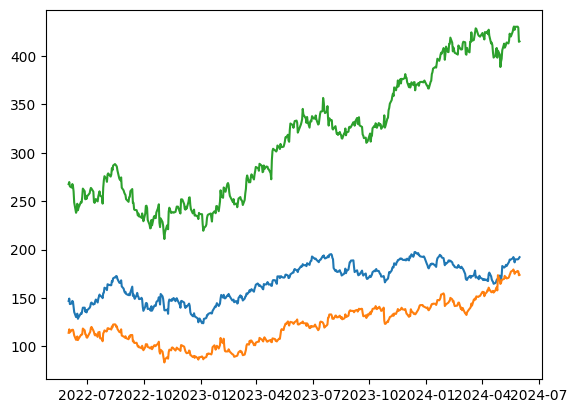

['AAPL' 'GOOG' 'MSFT']


[*********************100%%**********************]  2 of 2 completed

Ticker            ^GSPC         ^IXIC
Date                                 
2022-06-01  4101.229980  11994.459961
2022-06-02  4176.819824  12316.900391
2022-06-03  4108.540039  12012.730469
2022-06-06  4121.430176  12061.370117
2022-06-07  4160.680176  12175.230469
...                 ...           ...
2024-05-24  5304.720215  16920.789062
2024-05-28  5306.040039  17019.880859
2024-05-29  5266.950195  16920.580078
2024-05-30  5235.479980  16737.080078
2024-05-31  5277.509766  16735.019531

[503 rows x 2 columns]
[[ 4101.22998047  4176.81982422  4108.54003906 ...  5266.95019531
   5235.47998047  5277.50976562]
 [11994.45996094 12316.90039062 12012.73046875 ... 16920.58007812
  16737.08007812 16735.01953125]]


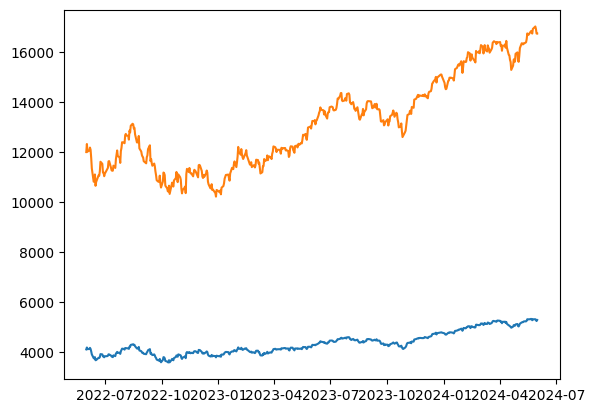

['^GSPC' '^IXIC']
['2022-06-01T00:00:00.000000000' '2022-06-02T00:00:00.000000000'
 '2022-06-03T00:00:00.000000000' '2022-06-06T00:00:00.000000000'
 '2022-06-07T00:00:00.000000000' '2022-06-08T00:00:00.000000000'
 '2022-06-09T00:00:00.000000000' '2022-06-10T00:00:00.000000000'
 '2022-06-13T00:00:00.000000000' '2022-06-14T00:00:00.000000000'
 '2022-06-15T00:00:00.000000000' '2022-06-16T00:00:00.000000000'
 '2022-06-17T00:00:00.000000000' '2022-06-21T00:00:00.000000000'
 '2022-06-22T00:00:00.000000000' '2022-06-23T00:00:00.000000000'
 '2022-06-24T00:00:00.000000000' '2022-06-27T00:00:00.000000000'
 '2022-06-28T00:00:00.000000000' '2022-06-29T00:00:00.000000000'
 '2022-06-30T00:00:00.000000000' '2022-07-01T00:00:00.000000000'
 '2022-07-05T00:00:00.000000000' '2022-07-06T00:00:00.000000000'
 '2022-07-07T00:00:00.000000000' '2022-07-08T00:00:00.000000000'
 '2022-07-11T00:00:00.000000000' '2022-07-12T00:00:00.000000000'
 '2022-07-13T00:00:00.000000000' '2022-07-14T00:00:00.000000000'
 '2022-

In [21]:
data = yf.download("MSFT AAPL GOOG", period="2y")['Adj Close']
print(data)
D = data.to_numpy().T
print(D)
plt.plot(data)
plt.show()

D_tickers = data.columns.values
print(D_tickers)

benchmarks = yf.download("^IXIC ^GSPC", period="2y")["Adj Close"]
print(benchmarks)
B = benchmarks.to_numpy().T
print(B)
plt.plot(benchmarks)
plt.show()

B_tickers = benchmarks.columns.values
print(B_tickers)

dates = data.index.values
print(dates)

Learning from scratch


/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 931, function evaluations: 2910040, CG iterations: 7090, optimality: 4.74e-01, constraint violation: 7.77e-16, execution time: 1.5e+03 s.


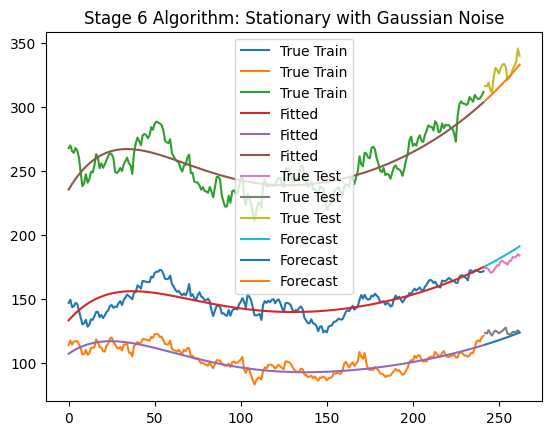

Ticker            AAPL                                               GOOG  \
Metric              p1          p2  L/S      Gain Percent P&L          p1   
2023-05-18  174.125259  183.943115    L  9.817856    5.638387  123.519997   
2023-06-20         NaN         NaN  NaN       NaN         NaN         NaN   
2023-07-20         NaN         NaN  NaN       NaN         NaN         NaN   
2023-08-18         NaN         NaN  NaN       NaN         NaN         NaN   
2023-09-19         NaN         NaN  NaN       NaN         NaN         NaN   
2023-10-18         NaN         NaN  NaN       NaN         NaN         NaN   

Ticker                                             ...        ^GSPC  \
Metric              p2  L/S      Gain Percent P&L  ...           p1   
2023-05-18  124.059998    L  0.540001    0.437177  ...  4198.049805   
2023-06-20         NaN  NaN       NaN         NaN  ...          NaN   
2023-07-20         NaN  NaN       NaN         NaN  ...          NaN   
2023-08-18         NaN  NaN 

/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 151, function evaluations: 487285, CG iterations: 382, optimality: 4.62e-01, constraint violation: 3.33e-16, execution time: 1.9e+02 s.


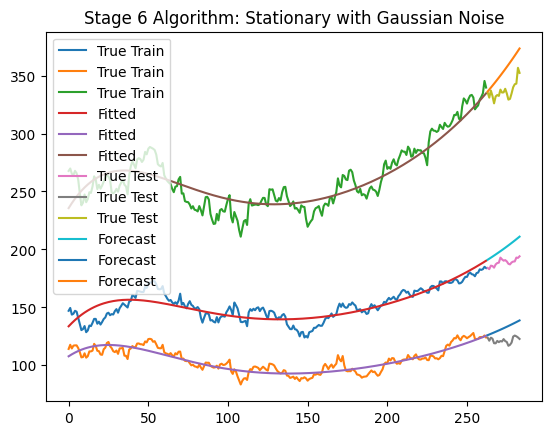

Ticker            AAPL                                                GOOG  \
Metric              p1          p2  L/S       Gain Percent P&L          p1   
2023-05-18  174.125259  183.943115    L   9.817856    5.638387  123.519997   
2023-06-20  184.032623  194.069351    L  10.036728    5.453776  123.849998   
2023-07-20         NaN         NaN  NaN        NaN         NaN         NaN   
2023-08-18         NaN         NaN  NaN        NaN         NaN         NaN   
2023-09-19         NaN         NaN  NaN        NaN         NaN         NaN   
2023-10-18         NaN         NaN  NaN        NaN         NaN         NaN   

Ticker                                             ...        ^GSPC  \
Metric              p2  L/S      Gain Percent P&L  ...           p1   
2023-05-18  124.059998    L  0.540001    0.437177  ...  4198.049805   
2023-06-20  122.779999    L     -1.07   -0.863948  ...  4388.709961   
2023-07-20         NaN  NaN       NaN         NaN  ...          NaN   
2023-08-18         N

/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 524, function evaluations: 1519072, CG iterations: 1336, optimality: 4.90e-01, constraint violation: 4.44e-16, execution time: 9.1e+02 s.


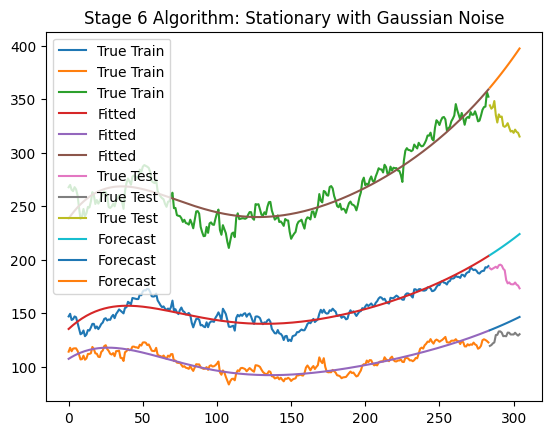

Ticker            AAPL                                                GOOG  \
Metric              p1          p2  L/S       Gain Percent P&L          p1   
2023-05-18  174.125259  183.943115    L   9.817856    5.638387  123.519997   
2023-06-20  184.032623  194.069351    L  10.036728    5.453776  123.849998   
2023-07-20  192.109756  173.314545    L -18.795212    -9.78358  119.529999   
2023-08-18         NaN         NaN  NaN        NaN         NaN         NaN   
2023-09-19         NaN         NaN  NaN        NaN         NaN         NaN   
2023-10-18         NaN         NaN  NaN        NaN         NaN         NaN   

Ticker                                              ...        ^GSPC  \
Metric              p2  L/S       Gain Percent P&L  ...           p1   
2023-05-18  124.059998    L   0.540001    0.437177  ...  4198.049805   
2023-06-20  122.779999    L      -1.07   -0.863948  ...  4388.709961   
2023-07-20  130.460007    L  10.930008    9.144155  ...  4534.870117   
2023-08-18     

/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 376, function evaluations: 1427090, CG iterations: 1834, optimality: 4.47e-01, constraint violation: 4.44e-16, execution time: 6.7e+02 s.


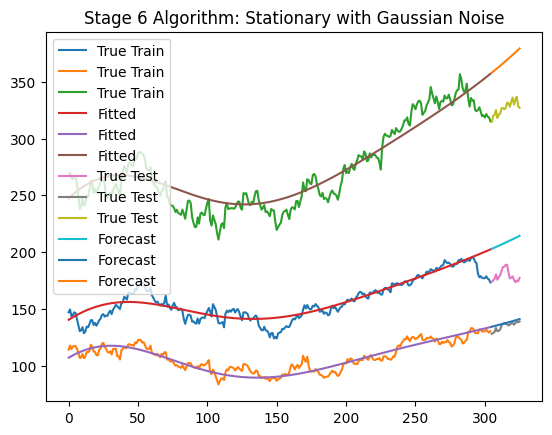

Ticker            AAPL                                                GOOG  \
Metric              p1          p2  L/S       Gain Percent P&L          p1   
2023-05-18  174.125259  183.943115    L   9.817856    5.638387  123.519997   
2023-06-20  184.032623  194.069351    L  10.036728    5.453776  123.849998   
2023-07-20  192.109756  173.314545    L -18.795212    -9.78358  119.529999   
2023-08-18  173.802612  177.268906    L   3.466293    1.994385  128.110001   
2023-09-19         NaN         NaN  NaN        NaN         NaN         NaN   
2023-10-18         NaN         NaN  NaN        NaN         NaN         NaN   

Ticker                                              ...        ^GSPC  \
Metric              p2  L/S       Gain Percent P&L  ...           p1   
2023-05-18  124.059998    L   0.540001    0.437177  ...  4198.049805   
2023-06-20  122.779999    L      -1.07   -0.863948  ...  4388.709961   
2023-07-20  130.460007    L  10.930008    9.144155  ...  4534.870117   
2023-08-18  138

/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 196, function evaluations: 771328, CG iterations: 452, optimality: 4.60e-01, constraint violation: 2.00e-15, execution time: 3.8e+02 s.


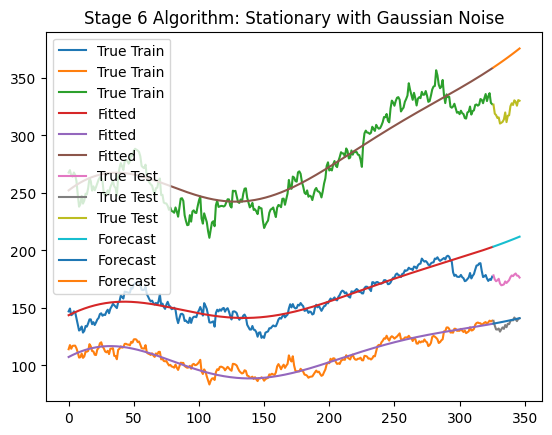

Ticker            AAPL                                                GOOG  \
Metric              p1          p2  L/S       Gain Percent P&L          p1   
2023-05-18  174.125259  183.943115    L   9.817856    5.638387  123.519997   
2023-06-20  184.032623  194.069351    L  10.036728    5.453776  123.849998   
2023-07-20  192.109756  173.314545    L -18.795212    -9.78358  119.529999   
2023-08-18  173.802612  177.268906    L   3.466293    1.994385  128.110001   
2023-09-19  178.364563  176.452118    L  -1.912445   -1.072211  138.830002   
2023-10-18         NaN         NaN  NaN        NaN         NaN         NaN   

Ticker                                              ...        ^GSPC  \
Metric              p2  L/S       Gain Percent P&L  ...           p1   
2023-05-18  124.059998    L   0.540001    0.437177  ...  4198.049805   
2023-06-20  122.779999    L      -1.07   -0.863948  ...  4388.709961   
2023-07-20  130.460007    L  10.930008    9.144155  ...  4534.870117   
2023-08-18  138

/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 230, function evaluations: 883506, CG iterations: 1074, optimality: 4.56e-01, constraint violation: 1.11e-15, execution time: 5e+02 s.


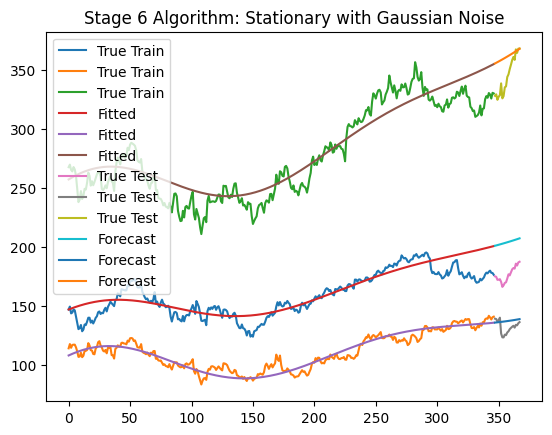

Ticker            AAPL                                               GOOG  \
Metric              p1          p2 L/S       Gain Percent P&L          p1   
2023-05-18  174.125259  183.943115   L   9.817856    5.638387  123.519997   
2023-06-20  184.032623  194.069351   L  10.036728    5.453776  123.849998   
2023-07-20  192.109756  173.314545   L -18.795212    -9.78358  119.529999   
2023-08-18  173.802612  177.268906   L   3.466293    1.994385  128.110001   
2023-09-19  178.364563  176.452118   L  -1.912445   -1.072211  138.830002   
2023-10-18  175.147278  187.516052   L  12.368774    7.061928  139.279999   

Ticker                                             ...        ^GSPC  \
Metric              p2 L/S       Gain Percent P&L  ...           p1   
2023-05-18  124.059998   L   0.540001    0.437177  ...  4198.049805   
2023-06-20  122.779999   L      -1.07   -0.863948  ...  4388.709961   
2023-07-20  130.460007   L  10.930008    9.144155  ...  4534.870117   
2023-08-18  138.960007   L  

In [23]:
trader = SimulatedTrades(D=D, B=B, D_tickers=D_tickers, B_tickers=B_tickers, dates=dates)

step, k, num_periods, test_len = 21, 1, 6, 21
trader.simulate(n=D.shape[1]-(step-1)*num_periods*2, step=step, num_periods=num_periods, k=k, test_len=test_len)

In [41]:
pnl = trader.pnl.loc[:, pd.IndexSlice[:, 'Percent P&L']].copy()

pnl[('Ticker', 'Avg_AAPL_GOOG_MSFT')] = pnl.loc[:, pd.IndexSlice[['AAPL', 'GOOG', 'MSFT'], :]].mean(axis=1)
pnl[('Ticker', 'Avg_GSPC_IXIC')] = pnl.loc[:, pd.IndexSlice[['^GSPC', '^IXIC'], :]].mean(axis=1)

pnl

AttributeError: 'SimulatedTrades' object has no attribute 'pnl'

In [ ]:
budget_per = 1000
pnl[('Ticker', 'Ret')] = pnl.loc[:, pd.IndexSlice[['AAPL'], :]] * budget_per / 100
pnl[('Ticker', 'Ret')] = pnl.loc[:, pd.IndexSlice[['GOOG'], :]] * budget_per / 100
pnl[('Ticker', 'Ret')] = pnl.loc[:, pd.IndexSlice[['MSFT'], :]] * budget_per / 100

pnl[('Ticker', 'Sum_ret')] = pnl.loc[:, pd.IndexSlice[['AAPL', 'GOOG', 'MSFT'], :]].sum(axis=1)

pnl

ValueError: Columns must be same length as key